In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymc_marketing.mmm import MMM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import data

In [3]:
df = pd.read_csv("mmm_data_01.csv", parse_dates=["week_ending"])
df = df.sort_values(by=["week_ending"]).reset_index(drop=True)
df = df[["week_ending", "spend_ppc_nb", "spend_ppc_b", "spend_social", "imp_seo", "demand", "conversions"]]
df

,week_ending,spend_ppc_nb,spend_ppc_b,spend_social,imp_seo,demand,conversions
0,2021-01-03,5249.82,8892.61,23654.36,181049,72,1989
1,2021-01-10,6559.41,14710.67,51764.77,149213,71,1807
2,2021-01-17,4480.64,15685.86,54968.74,143316,73,1833
3,2021-01-24,3566.58,18022.25,52360.92,149786,75,1921
4,2021-01-31,13171.17,19528.00,147908.35,173740,71,2341
...,...,...,...,...,...,...,...
173,2024-04-28,106030.07,21209.89,53475.76,621504,81,2247
174,2024-05-05,137776.76,21601.90,52552.17,667976,78,2688
175,2024-05-12,78721.38,17308.82,56726.01,656537,72,2058
176,2024-05-19,60470.16,17172.98,47983.05,623004,76,1729


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   week_ending   178 non-null    datetime64[ns]
 1   spend_ppc_nb  178 non-null    float64       
 2   spend_ppc_b   178 non-null    float64       
 3   spend_social  178 non-null    float64       
 4   imp_seo       178 non-null    int64         
 5   demand        178 non-null    int64         
 6   conversions   178 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 9.9 KB


In [5]:
date_col = "week_ending"

y_col = "conversions"

channel_cols = ["spend_ppc_nb",
                "spend_ppc_b",
                "spend_social",
                "imp_seo",
]

control_cols = ["demand",
]

# EDA

### Time series analysis

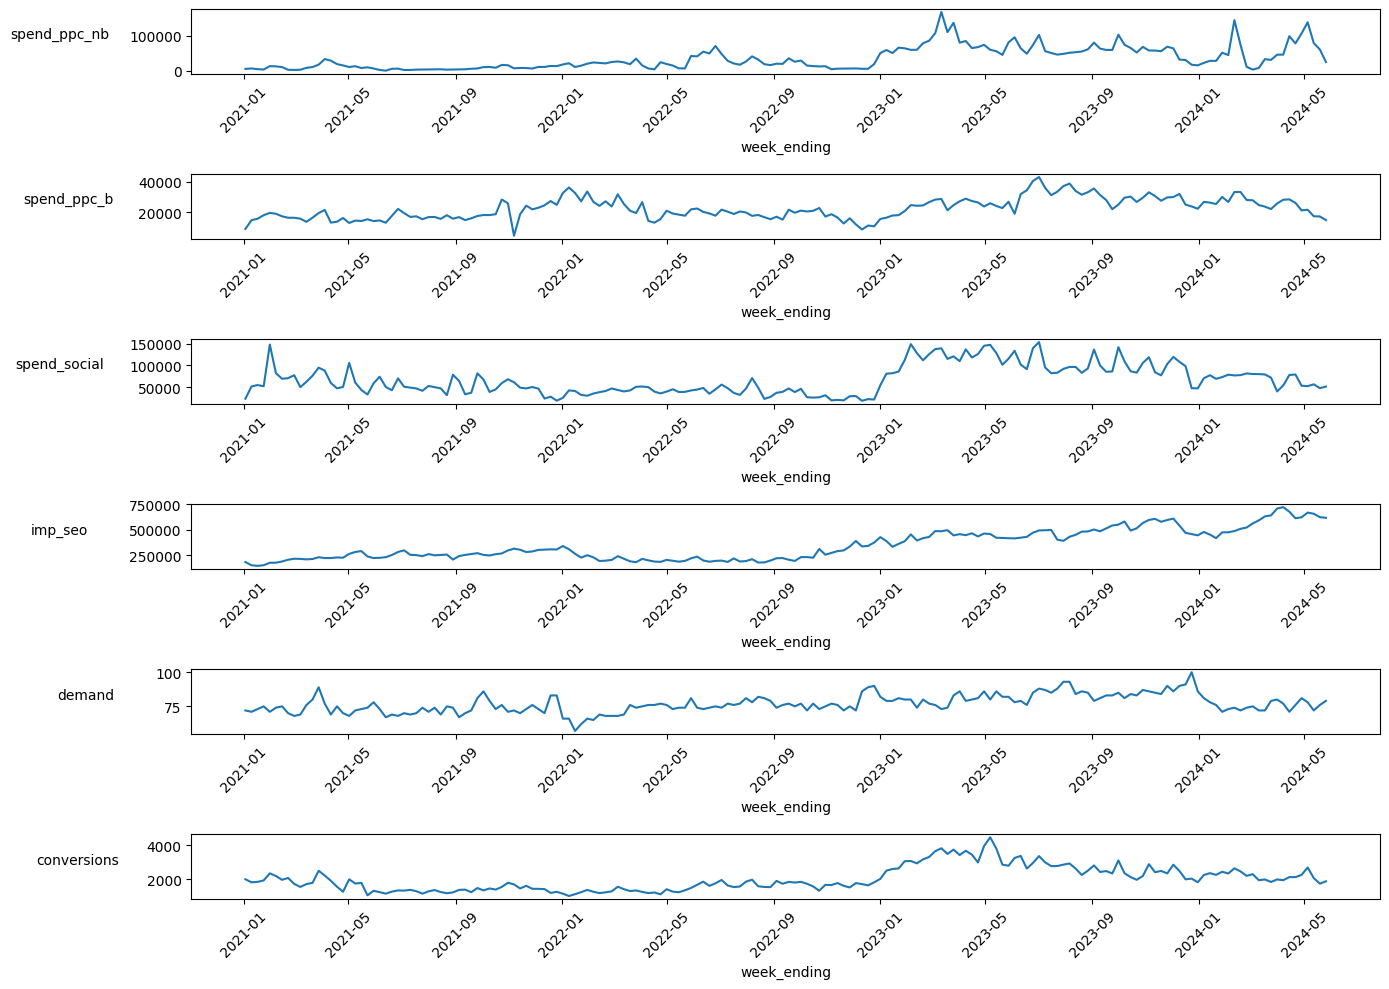

In [6]:
plt.figure(figsize=(14, 10))

for i, column in enumerate(df.columns):
    if column != date_col: 
        plt.subplot(len(df.columns) - 1, 1, i) 
        sns.lineplot(data=df, x=date_col, y=column)
        plt.ylabel(column)
        plt.ylabel(column, rotation=0, labelpad=50) 
        plt.xticks(rotation=45) 
        plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

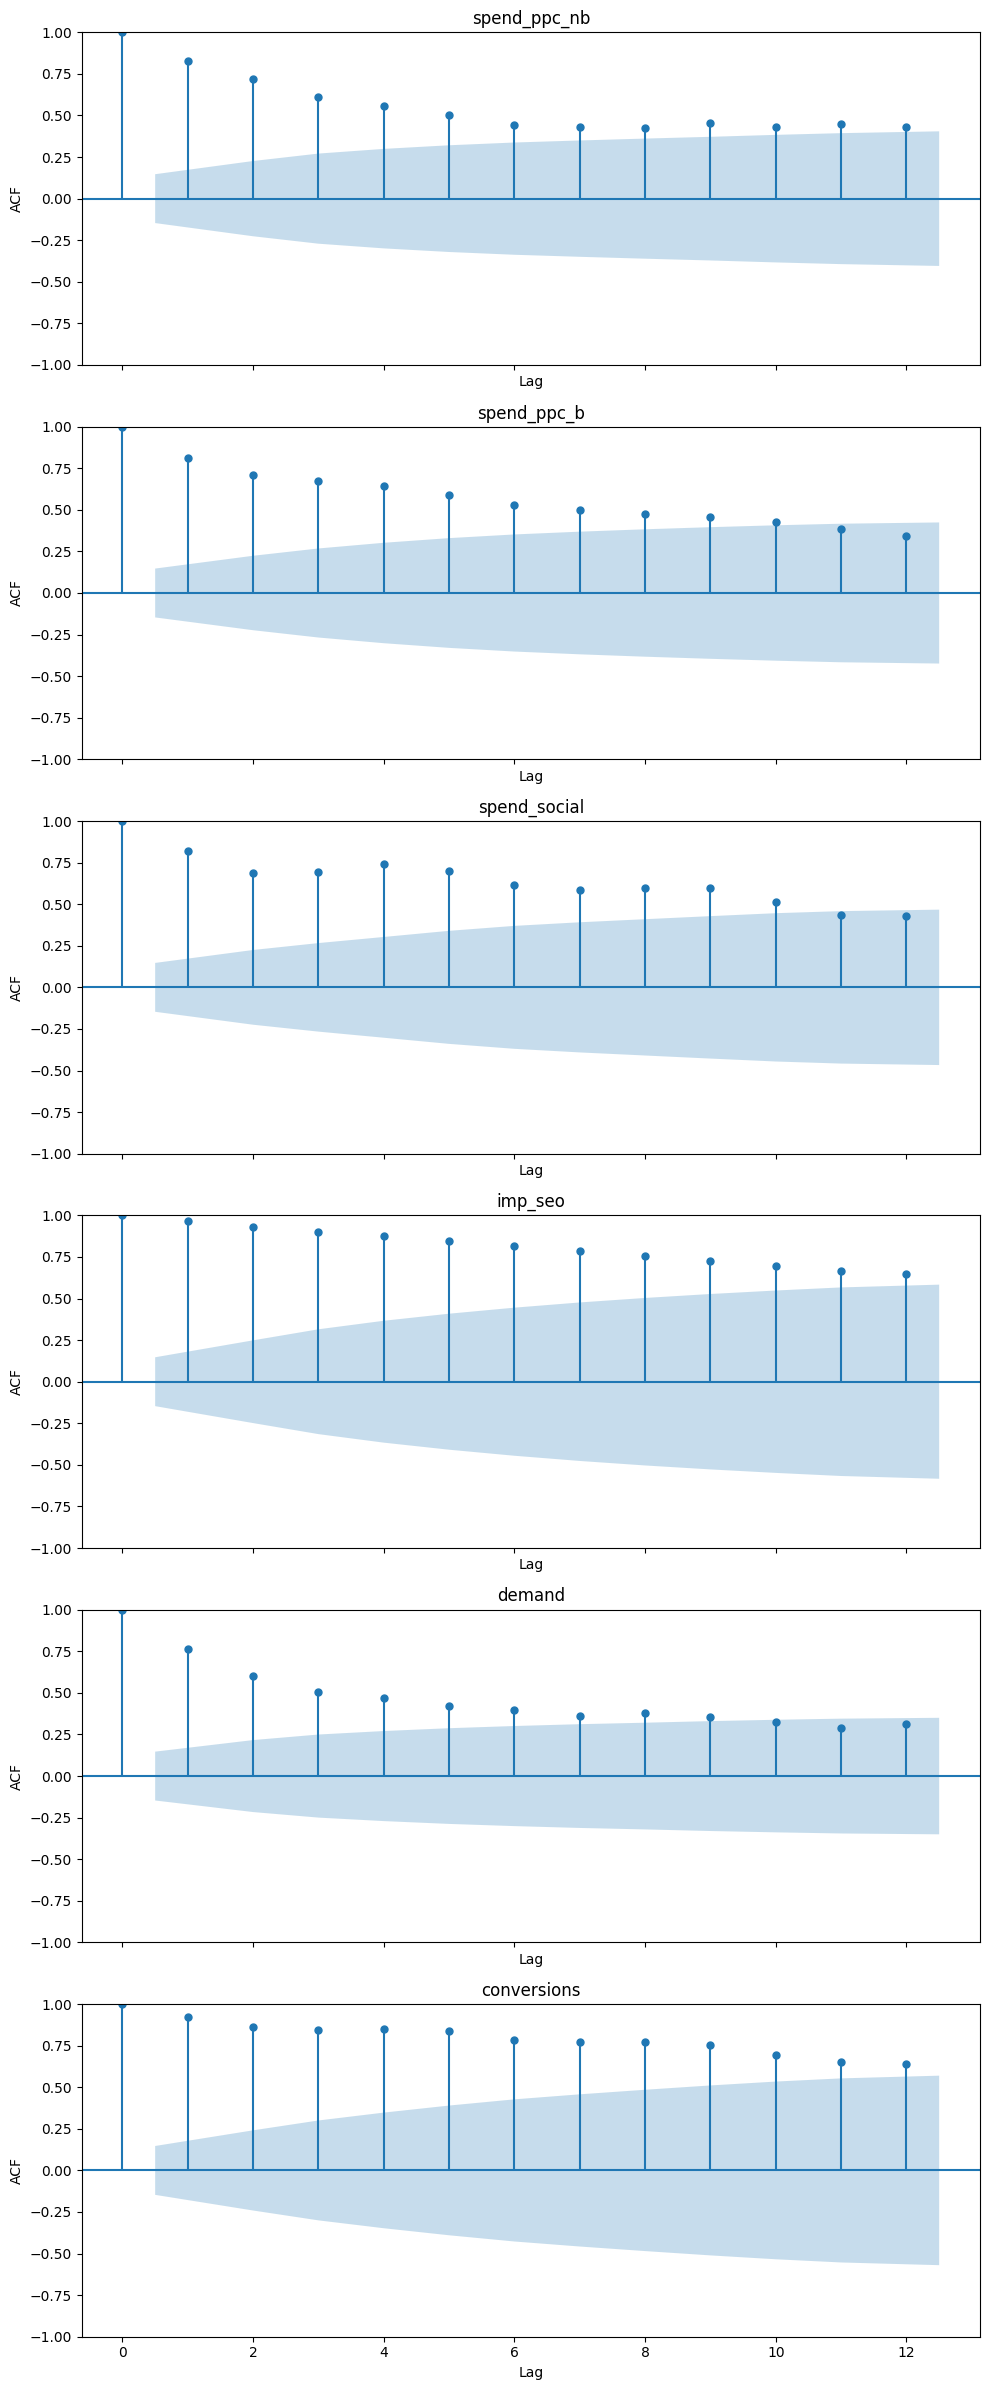

In [7]:
def plot_acf_for_columns(df, max_lags=20):
    num_features = len(df.columns)
    
    fig, axes = plt.subplots(num_features, 1, figsize=(10, 4 * num_features), sharex=True)
    
    for i, column in enumerate(df.columns):
        ax = axes[i]
        plot_acf(df[column], lags=max_lags, ax=ax, title=column)
        ax.set_xlabel('Lag')
        ax.set_ylabel('ACF')
    
    plt.tight_layout()
    plt.show()

# Define the maximum number of lags you want to consider
max_lags = 12

# Call the function to plot ACF
plot_acf_for_columns(df[channel_cols + control_cols + [y_col]], max_lags)

### Bi-variate analysis

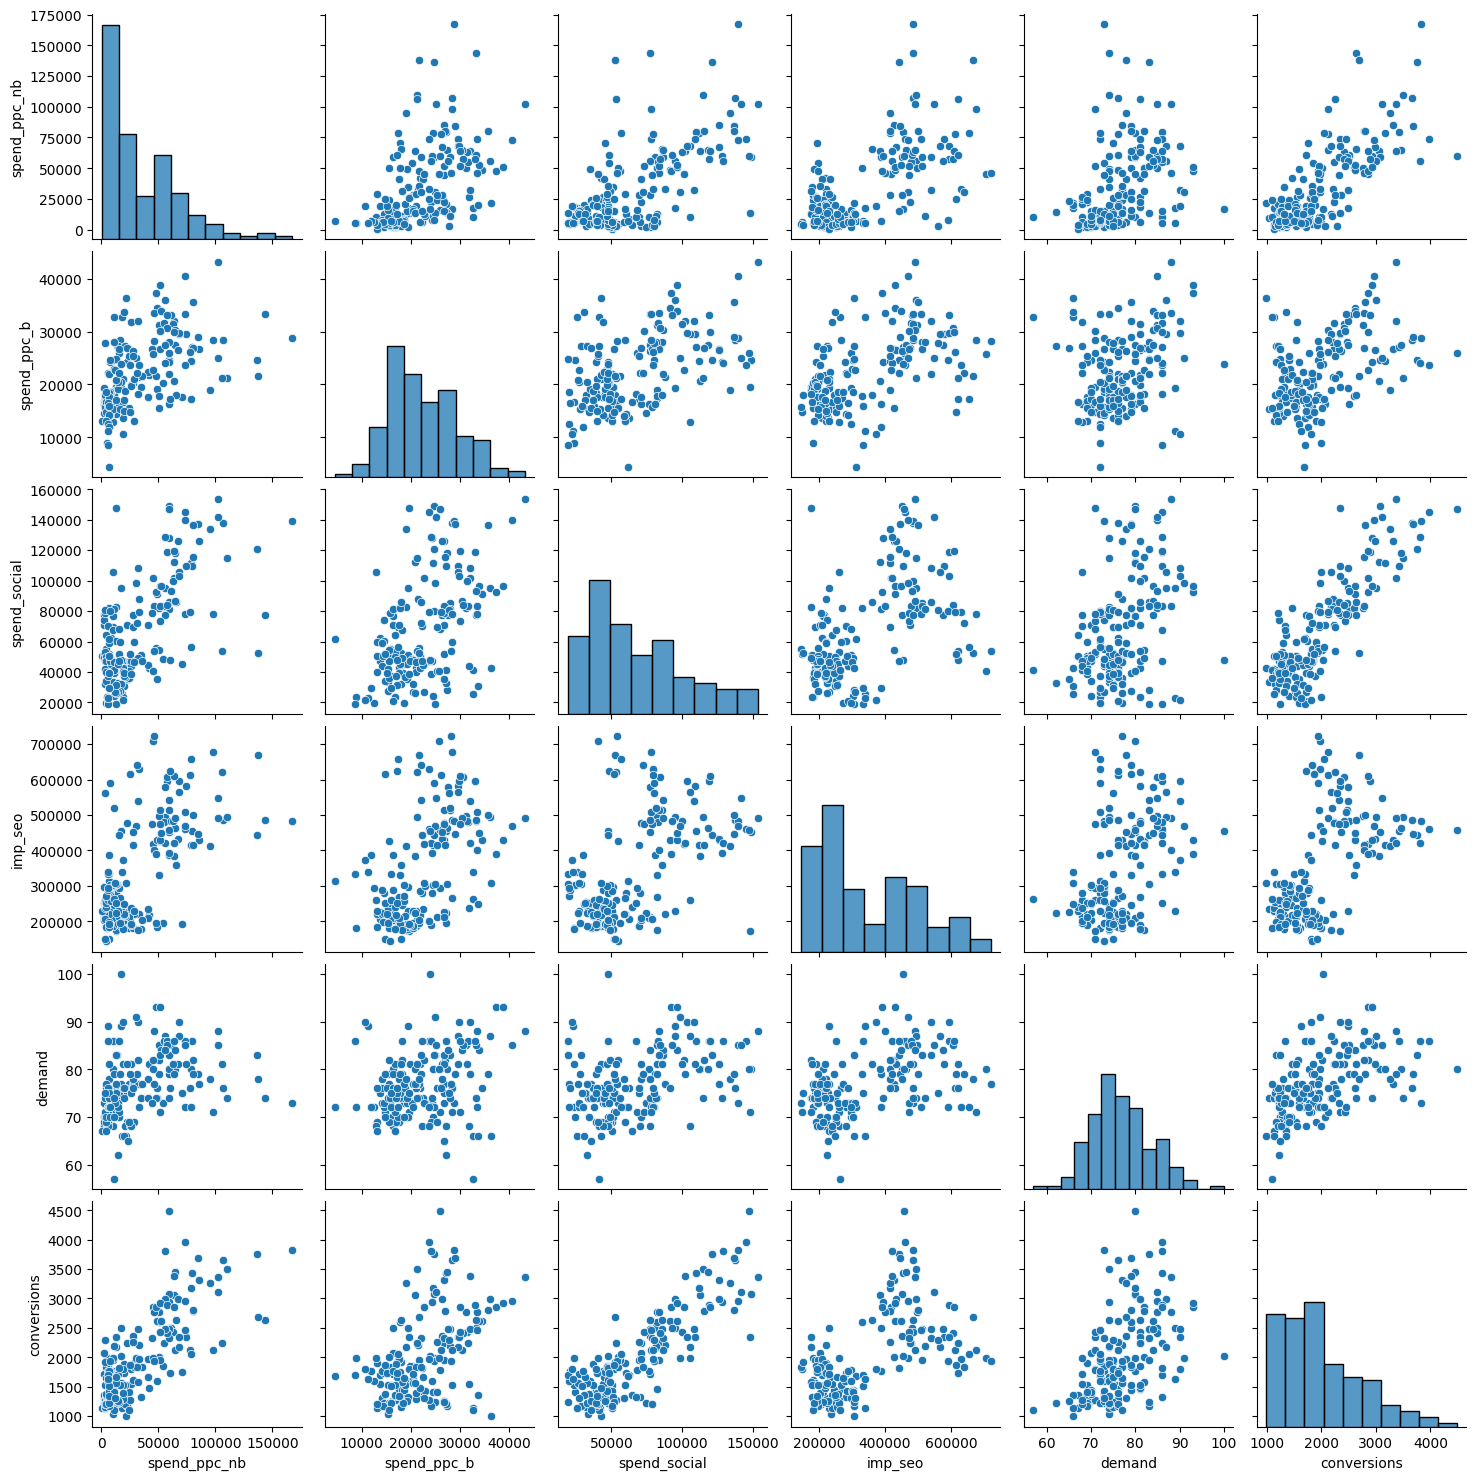

In [8]:
sns.pairplot(df)

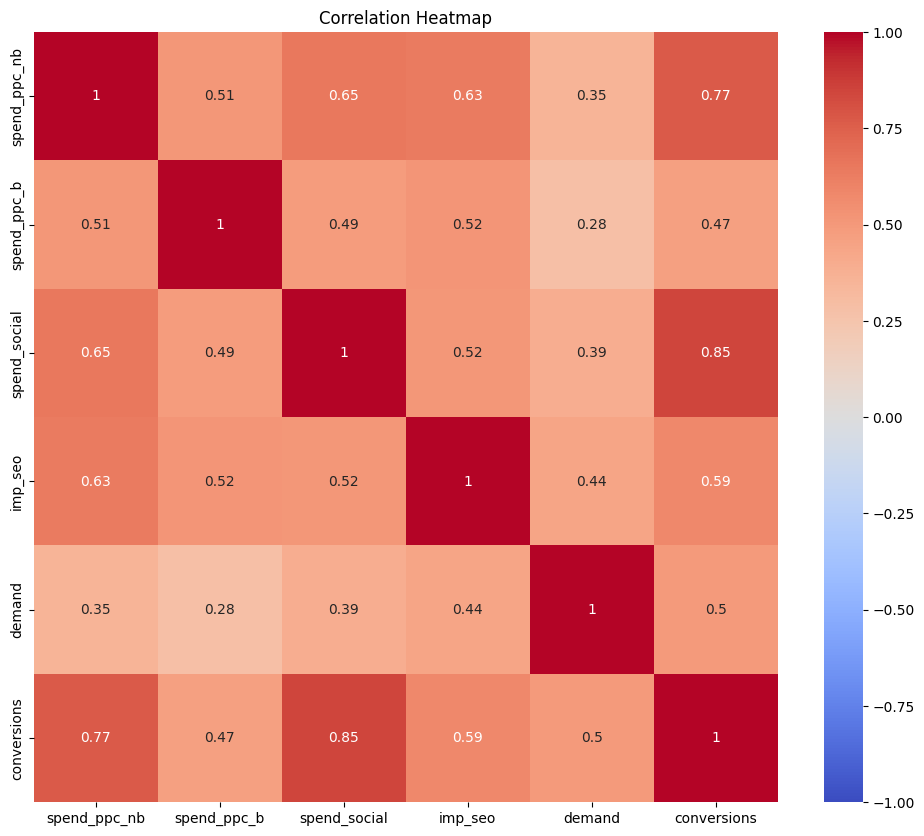

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[channel_cols + control_cols + [y_col]].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
vif_data = pd.DataFrame()
vif_data['feature'] = channel_cols + control_cols
vif_data['VIF'] = [variance_inflation_factor(df[channel_cols + control_cols].values, i) for i in range(df[channel_cols + control_cols].shape[1])]
vif_data

,feature,VIF
0,spend_ppc_nb,4.818451
1,spend_ppc_b,17.292766
2,spend_social,9.613691
3,imp_seo,12.750672
4,demand,16.439006


### Decomposition

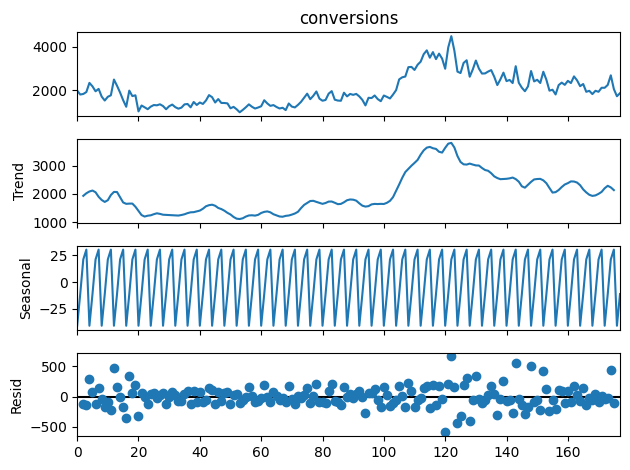

In [11]:
result = seasonal_decompose(df[y_col], period=4)
result.plot()
plt.show()


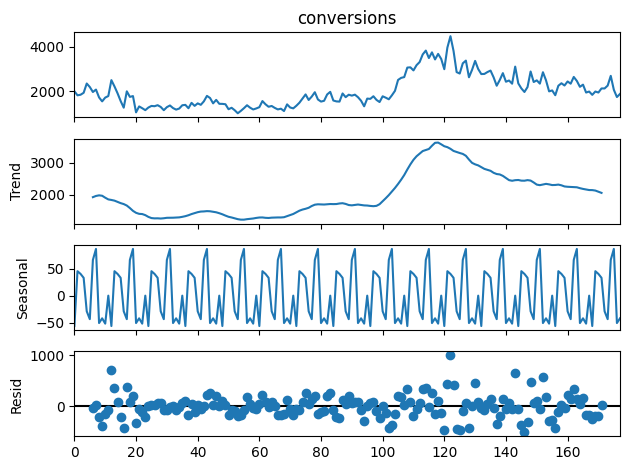

In [12]:
result = seasonal_decompose(df[y_col], period=12)
result.plot()
plt.show()

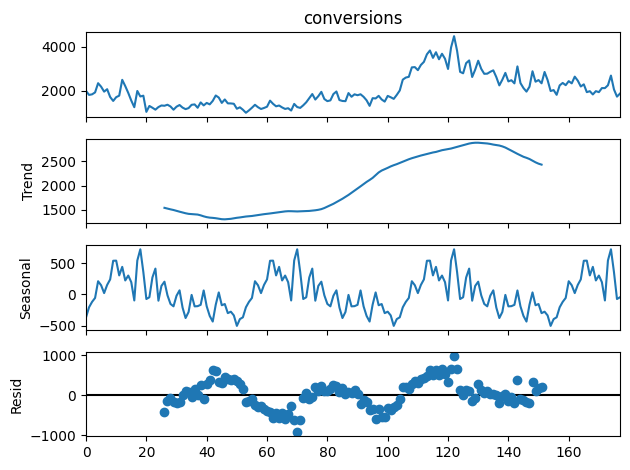

In [13]:
result = seasonal_decompose(df[y_col], period=52)
result.plot()
plt.show()

### Ad stock

### Saturation

# Model training

In [ ]:
# how can we set adstock
# how can we set saturation
# how can we set priors
# how should we set seasonality
# can we tune the parameters or do we need to use hyper-opt?
# store tuning results with mlflow

In [75]:
mmm = MMM(
    adstock="geometric",
    saturation="logistic",
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
    adstock_max_lag=4,
    yearly_seasonality=2,
)

mmm.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal',
  'kwargs': {'mu': 0, 'sigma': 2},
  'dims': 'control'},
 'gamma_fourier': {'dist': 'Laplace',
  'kwargs': {'mu': 0, 'b': 1},
  'dims': 'fourier_mode'},
 'adstock_alpha': {'dist': 'Beta',
  'kwargs': {'alpha': 1, 'beta': 3},
  'dims': 'channel'},
 'saturation_lam': {'dist': 'Gamma',
  'kwargs': {'alpha': 3, 'beta': 1},
  'dims': 'channel'},
 'saturation_beta': {'dist': 'HalfNormal',
  'kwargs': {'sigma': 2},
  'dims': 'channel'}}

In [76]:
X = df[[date_col] + channel_cols + control_cols]
y = df[y_col]

mmm.fit(X, y)
mmm.save("model.nc")

c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\pymc_marketing\venv\Lib\site-packages\pymc\model\core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\pymc_marketing\venv\Lib\site-packages\pymc\model\core.py:988: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\pymc_marketing\venv\Lib\site-packages\pymc\data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\pymc_marketing\venv\Lib\site-packages\pymc\data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will rai

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


# Model validation

In [ ]:
# get y, yhat and contributions in a dataframe
# is there a train/test split we can look at?
# what diagnostics should we do?

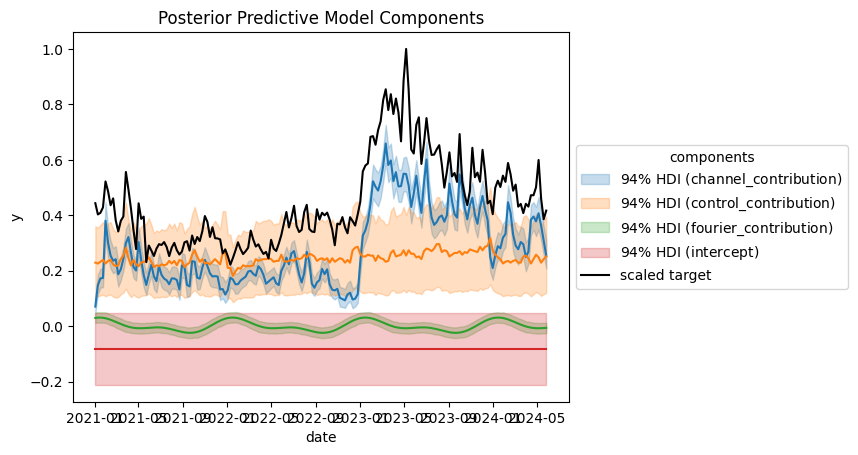

In [77]:
mmm.plot_components_contributions();

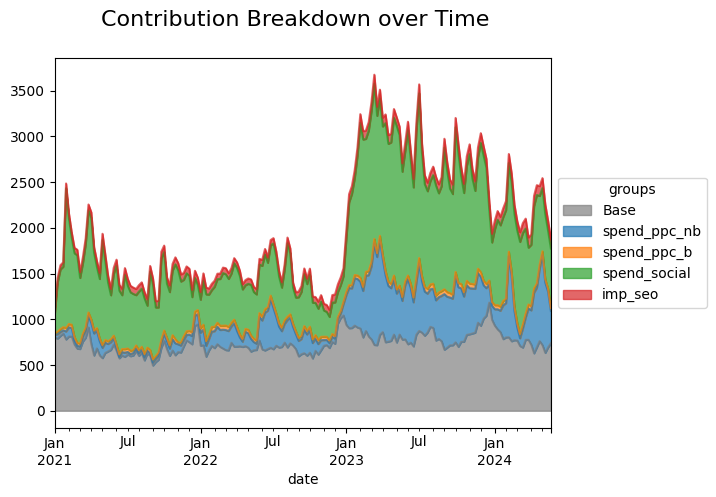

In [78]:
groups = {
    "Base": [
        "intercept",
        "demand",
        "yearly_seasonality",
    ],
    "spend_ppc_nb": ["spend_ppc_nb"],
    "spend_ppc_b": ["spend_ppc_b"],
    "spend_social": ["spend_social"],
    "imp_seo": ["imp_seo"],    
    
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "spend_ppc_nb": "C0",
            "spend_ppc_b": "C1",
            "spend_social": "C2",
            "imp_seo": "C3",            
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

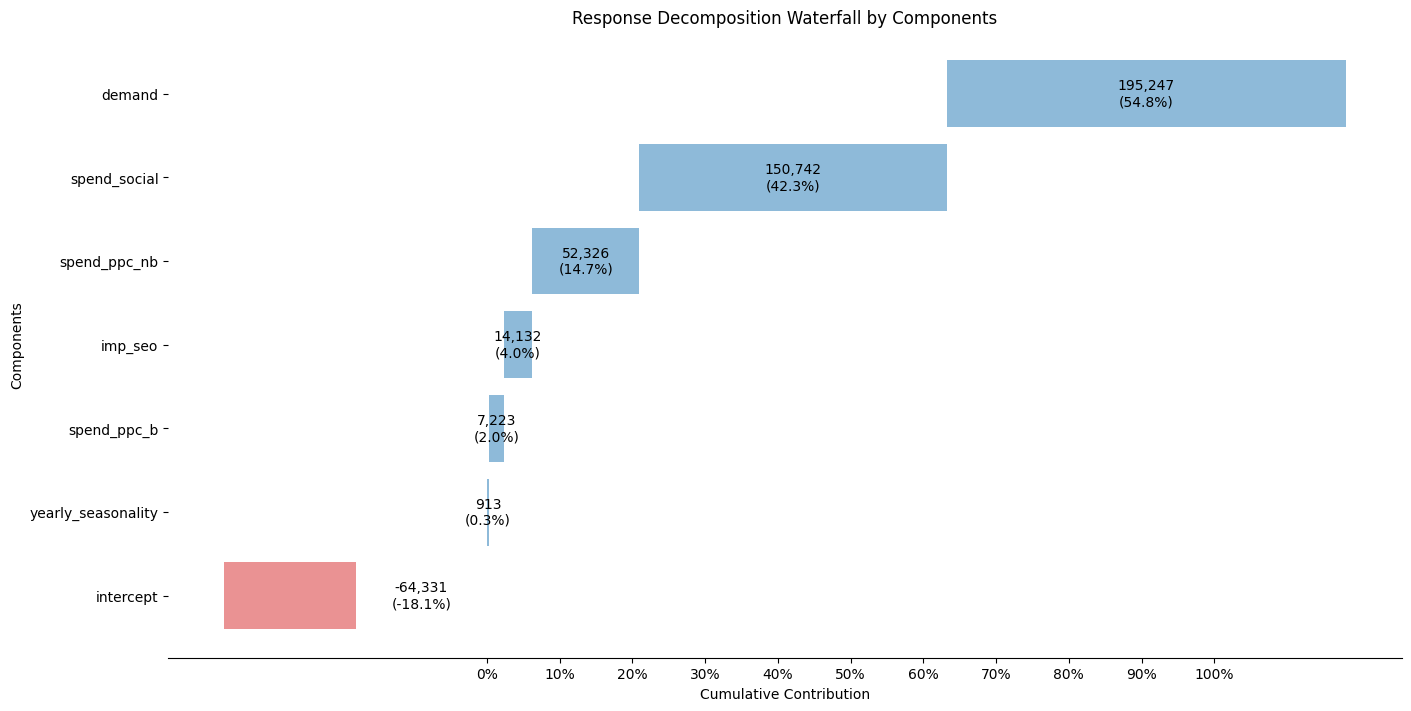

In [79]:
mmm.plot_waterfall_components_decomposition();

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


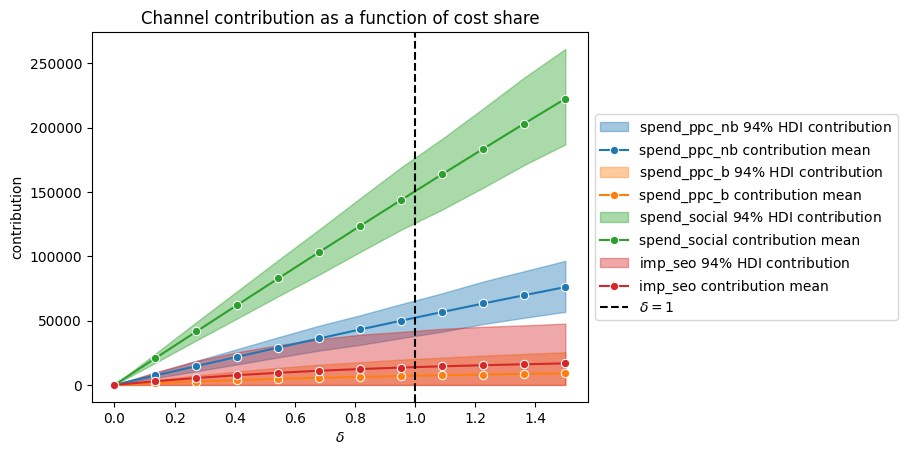

In [12]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12);

# Lift test calibration

In [ ]:
# the results suggest i haven't populated this correctly
# need to check if this needs to be weekly impact
# need to check what sigma is

In [13]:
df_lift_test = pd.DataFrame({"channel": ["spend_social"],
                             "x": [0],
                             "delta_x": [100000 / 4],
                             "delta_y": [3500 / 4],
                             "sigma": [0.05]
})

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,spend_social,0,25000.0,875.0,0.05


In [15]:
mmm.add_lift_test_measurements(df_lift_test)
mmm.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1375 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

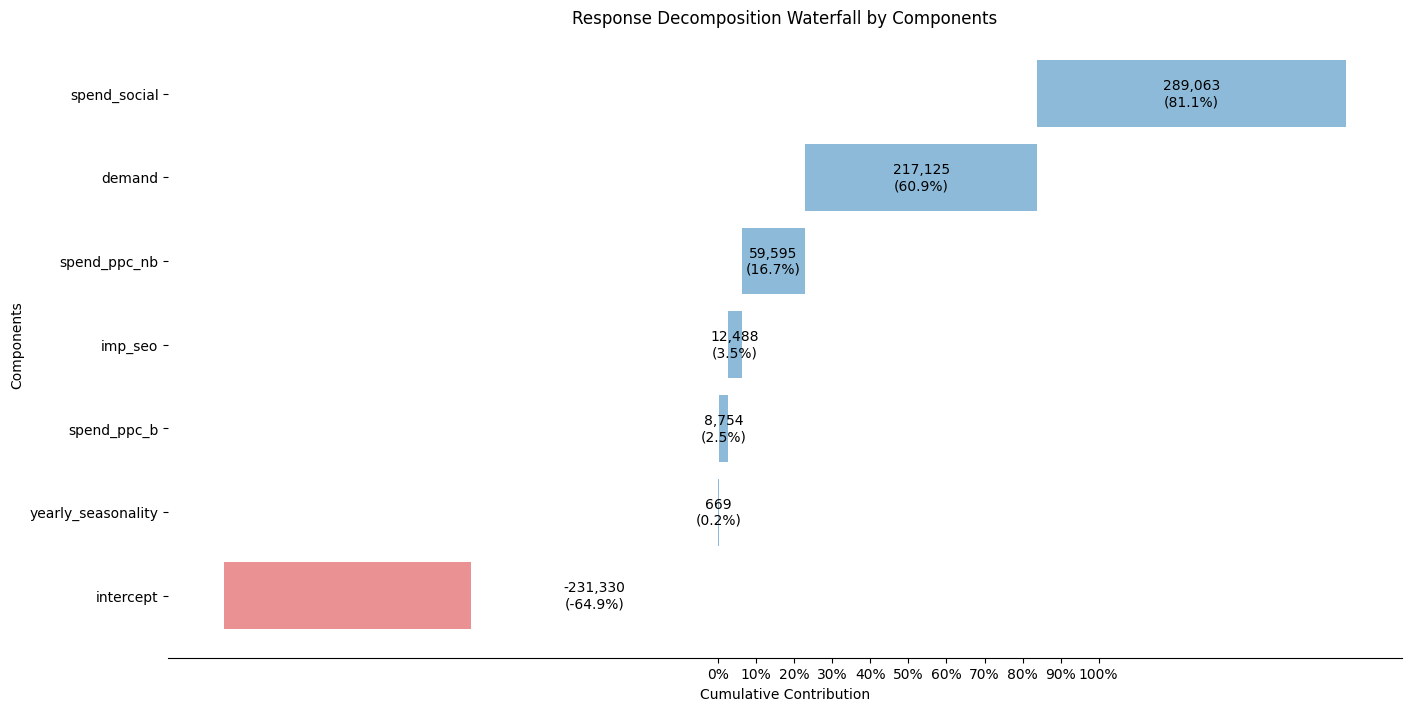

In [16]:
mmm.plot_waterfall_components_decomposition();